<a href="https://colab.research.google.com/github/Sudeesh07/Skin_disease_classification/blob/main/Skin_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sudeeshmuthum","key":"1eac2ce73f26d9866670a76863a6a79f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic

100% 783M/786M [00:22<00:00, 36.6MB/s]
100% 786M/786M [00:22<00:00, 36.9MB/s]


In [ ]:
!unzip skin-cancer9-classesisic.zip

Archive:  skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer 

In [ ]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import random
import cv2
import tensorflow as tf
import keras
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import pathlib
from keras.optimizers import Adam


In [ ]:
img_path = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0024799.jpg'
img_shape = cv2.imread(img_path).shape
img_shape

(450, 600, 3)

In [ ]:
mobile_net_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)

In [ ]:
mobile_net_model.output

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

In [ ]:
mobile_net_model.trainable =  False
x = tf.keras.layers.GlobalAveragePooling2D()(mobile_net_model.output)
output = tf.keras.layers.Dense(9, activation='softmax')(x)


In [ ]:
x

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [ ]:
mobile_net_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
mobile_net_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=30,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest',
validation_split = 0.2
)

In [ ]:
train_generator = datagen.flow_from_directory(
'/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train',
target_size=(224, 224),
batch_size=32,
subset = 'training',
class_mode='categorical',
shuffle=True
)
val_generator = datagen.flow_from_directory(
'/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train',
target_size=(224, 224),
batch_size=32,
subset = 'validation',
class_mode='categorical',
shuffle=True
)
test_generator = datagen.flow_from_directory(
'/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test',
target_size=(224, 224),
batch_size=32,
class_mode='categorical',
shuffle=False
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [ ]:
for layer in mobile_net_model.layers[:-4]:
    layer.trainable = False

In [ ]:
mobile_net_model = tf.keras.Model(inputs=mobile_net_model.input, outputs=output)

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_3')>

In [ ]:
mobile_net_model.compile(optimizer= Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.training_accuracy = []
        self.validation_accuracy = []

    def on_epoch_end(self, epoch, logs={}):
        self.training_accuracy.append(logs.get('accuracy'))
        self.validation_accuracy.append(logs.get('val_accuracy'))

accuracy_history = AccuracyHistory()

In [ ]:
y_pred = mobile_net_model.fit(train_generator, validation_data=val_generator, epochs=15,callbacks=[accuracy_history])

Epoch 1/15
57/57 [==============================] - 89s 2s/step - loss: 2.0317 - accuracy: 0.2702 - val_loss: 1.7002 - val_accuracy: 0.3716
Epoch 2/15
57/57 [==============================] - 83s 1s/step - loss: 1.6626 - accuracy: 0.3994 - val_loss: 1.6245 - val_accuracy: 0.3806
Epoch 3/15
57/57 [==============================] - 83s 1s/step - loss: 1.5460 - accuracy: 0.4429 - val_loss: 1.5496 - val_accuracy: 0.4212
Epoch 4/15
57/57 [==============================] - 84s 1s/step - loss: 1.4884 - accuracy: 0.4691 - val_loss: 1.4776 - val_accuracy: 0.4347
Epoch 5/15
57/57 [==============================] - 93s 2s/step - loss: 1.4540 - accuracy: 0.4747 - val_loss: 1.5859 - val_accuracy: 0.4459
Epoch 6/15
57/57 [==============================] - 84s 1s/step - loss: 1.4025 - accuracy: 0.4919 - val_loss: 1.5131 - val_accuracy: 0.4797
Epoch 7/15
57/57 [==============================] - 94s 2s/step - loss: 1.3429 - accuracy: 0.5242 - val_loss: 1.5075 - val_accuracy: 0.4932
Epoch 8/15
57/57 [==

Very Low accuracy due to imbalanced dataset

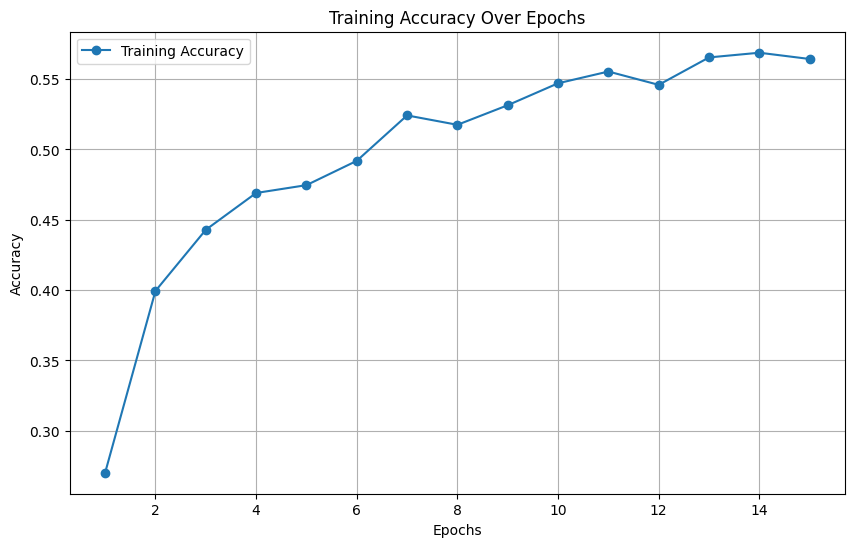

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, 16), accuracy_history.training_accuracy, label='Training Accuracy', marker='o', linestyle='-')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()


plt.grid(True)
plt.show()


total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

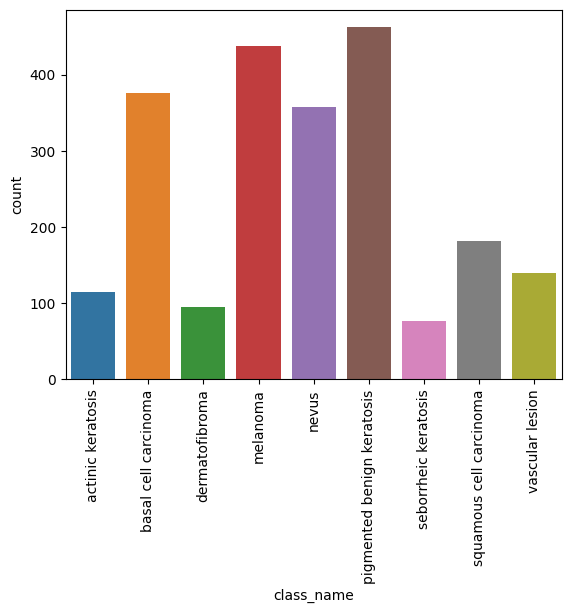

In [ ]:
num_classes = 9
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
total = 0
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
!pip install Augmentor


In [ ]:
import Augmentor

path_to_training_dataset = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
output_directory = '/content/augmented_data/'
os.makedirs(output_directory, exist_ok=True)

for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    p = Augmentor.Pipeline(class_path, output_directory=os.path.join(output_directory, class_name))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)


Initialised with 114 image(s) found.
Output directory set to /content/augmented_data/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B434828D360>: 100%|██████████| 1000/1000 [00:37<00:00, 26.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/augmented_data/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B434B317760>: 100%|██████████| 1000/1000 [00:36<00:00, 27.03 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/augmented_data/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B433A4EBFA0>: 100%|██████████| 1000/1000 [00:47<00:00, 21.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/augmented_data/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B433A446230>: 100%|██████████| 1000/1000 [03:11<00:00,  5.23 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/augmented_data/nevus.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7B433A35EC20>: 100%|██████████| 1000/1000 [02:55<00:00,  5.71 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/augmented_data/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B433A4E8070>: 100%|██████████| 1000/1000 [00:37<00:00, 26.73 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/augmented_data/seborrheic keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B4348241CC0>: 100%|██████████| 1000/1000 [01:30<00:00, 11.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/augmented_data/squamous cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B43480DE500>: 100%|██████████| 1000/1000 [00:40<00:00, 24.51 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/augmented_data/vascular lesion.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B434AB5C550>: 100%|██████████| 1000/1000 [00:40<00:00, 24.39 Samples/s]


In [ ]:
import os

directory_path = '/content/augmented_data'

image_extensions = ['.jpg', '.jpeg', '.png']
total_images = 0
for dirpath, dirnames, filenames in os.walk(directory_path):
    for filename in filenames:
        if any(filename.endswith(ext) for ext in image_extensions):
            total_images += 1
print(f'Number of images in the directory: {total_images}')


Number of images in the directory: 9000


In [ ]:
ntrain_dataset = datagen.flow_from_directory(
'/content/augmented_data/',
target_size=(224, 224),
batch_size=32,
subset = 'training',
class_mode='categorical',
shuffle=True
)
nval_generator = datagen.flow_from_directory(
'/content/augmented_data/',
target_size=(224, 224),
batch_size=32,
subset = 'validation',
class_mode='categorical',
shuffle=True
)

Found 7200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


Total training image count = 9000

-------------------------------------
Class name = actinic keratosis
Count      = 1000
Proportion = 0.1111111111111111
-------------------------------------
Class name = basal cell carcinoma
Count      = 1000
Proportion = 0.1111111111111111
-------------------------------------
Class name = dermatofibroma
Count      = 1000
Proportion = 0.1111111111111111
-------------------------------------
Class name = melanoma
Count      = 1000
Proportion = 0.1111111111111111
-------------------------------------
Class name = nevus
Count      = 1000
Proportion = 0.1111111111111111
-------------------------------------
Class name = pigmented benign keratosis
Count      = 1000
Proportion = 0.1111111111111111
-------------------------------------
Class name = seborrheic keratosis
Count      = 1000
Proportion = 0.1111111111111111
-------------------------------------
Class name = squamous cell carcinoma
Count      = 1000
Proportion = 0.1111111111111111
----------------

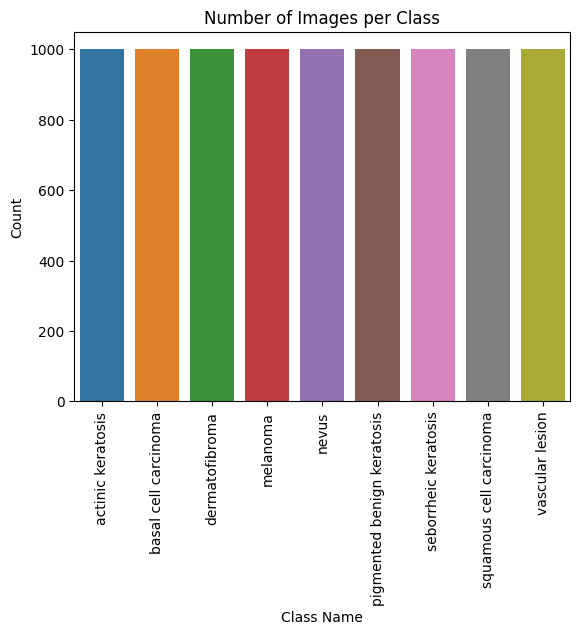

In [ ]:
output_dir_path = '/content/augmented_data'
output_dir = pathlib.Path(output_dir_path)
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
print("Total training image count = {}\n".format(total_images))
print("-------------------------------------")
class_name = []
all_count = []

for i in range(9):
    count = sum(1 for _ in output_dir.glob('**/' + class_names[i] + '*.jpg'))
    print("Class name =", class_names[i])
    print("Count      =", count)
    print("Proportion =", count / total_images)
    print("-------------------------------------")
    all_count.append(count)
    class_name.append(class_names[i])

count_df = pd.DataFrame(list(zip(all_count, class_name)), columns=['count', 'class_name'])

sns.barplot(data=count_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.title("Number of Images per Class")
plt.show()


In [ ]:
newmodel = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)
newmodel.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()(newmodel.output)
output = tf.keras.layers.Dense(9, activation='softmax')(x)
newmodel = tf.keras.Model(inputs=newmodel.input, outputs=output)
newmodel.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
num_classes

9

In [ ]:
num_classes=9

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/augmented_data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=32
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/augmented_data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=32
)


Found 9000 files belonging to 9 classes.
Using 7200 files for training.
Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
train_data.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
num_classes = 9

from tensorflow.keras import layers


model = Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(224,224,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 128)      

In [ ]:
model.compile(optimizer=Adam(learning_rate= 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
accuracy_history1 = AccuracyHistory()

In [ ]:
y_pred_new = model.fit(train_data, validation_data=val_data, epochs=15,callbacks=[accuracy_history1])

Epoch 1/15
  2/225 [..............................] - ETA: 20:04 - loss: 3.0863 - accuracy: 0.1406

KeyboardInterrupt: ignored

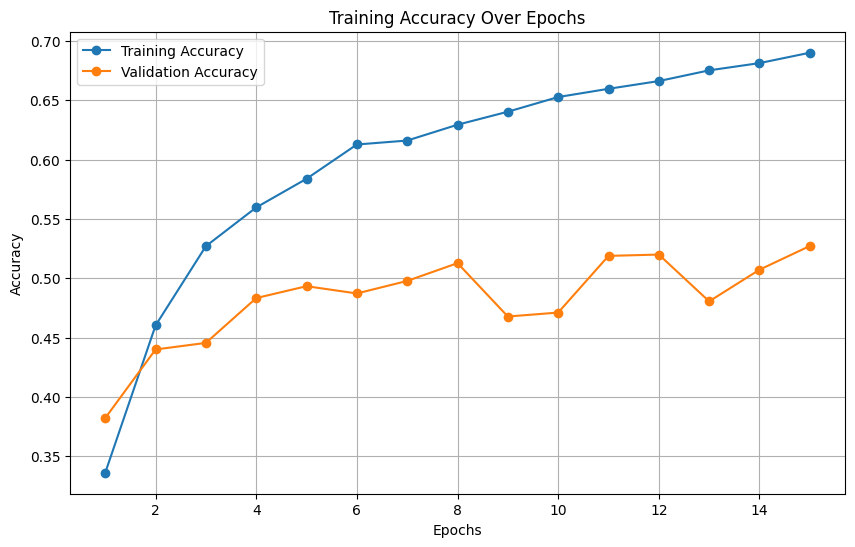

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, 16), accuracy_history1.training_accuracy, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(np.arange(1, 16), accuracy_history1.validation_accuracy, label='Validation Accuracy', marker='o', linestyle='-')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()


plt.grid(True)
plt.show()

In [ ]:
datagen = ImageDataGenerator(
rotation_range=30,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest',
validation_split = 0.2
)

In [ ]:
ntrain_generator = datagen.flow_from_directory(
'/content/augmented_data/',
target_size=(128,128),
batch_size=32,
subset = 'training',
class_mode='categorical',
seed = 123,
shuffle=True
)
nval_generator = datagen.flow_from_directory(
'/content/augmented_data/',
target_size=(128,128),
batch_size=32,
subset = 'validation',
class_mode='categorical',
shuffle=False,
seed = 123
)

In [ ]:
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128,128,3))
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_7 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_7 (Dropout)         (None, 20480)             0         
                                                                 
 dense_21 (Dense)            (None, 256)               5243136   
                                                                 
 dense_22 (Dense)            (None, 9)                 2313      
                                                                 
Total params: 7503433 (28.62 MB)
Trainable params: 524544

In [ ]:
model.compile(optimizer=Adam(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
accuracy_history2 = AccuracyHistory()

In [ ]:
y_pred_new = model.fit(ntrain_generator, validation_data=nval_generator, epochs=15,callbacks=[accuracy_history2])

Epoch 1/15
225/225 [==============================] - 106s 455ms/step - loss: 2.4314 - accuracy: 0.2281 - val_loss: 2.0474 - val_accuracy: 0.2011
Epoch 2/15
225/225 [==============================] - 104s 462ms/step - loss: 1.8690 - accuracy: 0.2817 - val_loss: 1.9692 - val_accuracy: 0.2472
Epoch 3/15
225/225 [==============================] - 100s 444ms/step - loss: 1.8299 - accuracy: 0.3001 - val_loss: 1.9898 - val_accuracy: 0.2778
Epoch 4/15
225/225 [==============================] - 104s 463ms/step - loss: 1.8165 - accuracy: 0.3004 - val_loss: 2.0106 - val_accuracy: 0.2711
Epoch 5/15
225/225 [==============================] - 101s 451ms/step - loss: 1.7886 - accuracy: 0.3111 - val_loss: 1.9394 - val_accuracy: 0.2939
Epoch 6/15
225/225 [==============================] - 115s 513ms/step - loss: 1.7656 - accuracy: 0.3232 - val_loss: 1.9569 - val_accuracy: 0.3011
Epoch 7/15
225/225 [==============================] - 109s 486ms/step - loss: 1.7524 - accuracy: 0.3233 - val_loss: 2.0385 -

KeyboardInterrupt: ignored

In [ ]:
folder_to_remove = '/content/augmented_data'
!rm -r "$folder_to_remove"

In [ ]:
import Augmentor

path_to_training_dataset = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
output_directory = '/content/augmented_data/'
os.makedirs(output_directory, exist_ok=True)

for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    p = Augmentor.Pipeline(class_path, output_directory=os.path.join(output_directory, class_name))
    p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
    p.random_contrast(probability=0.5, min_factor=0.5, max_factor=1.5)
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.flip_left_right(probability=0.5)
    p.flip_top_bottom(probability=0.5)
    p.sample(1000)


Initialised with 114 image(s) found.
Output directory set to /content/augmented_data/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE0A8D40400>: 100%|██████████| 1000/1000 [00:29<00:00, 34.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/augmented_data/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE0A69D6C80>: 100%|██████████| 1000/1000 [00:31<00:00, 32.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/augmented_data/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE0A40FBFA0>: 100%|██████████| 1000/1000 [00:31<00:00, 31.35 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/augmented_data/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EE0A8C15600>: 100%|██████████| 1000/1000 [02:27<00:00,  6.76 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/augmented_data/nevus.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7EE0A8E29030>: 100%|██████████| 1000/1000 [02:21<00:00,  7.07 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/augmented_data/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE14663CA00>: 100%|██████████| 1000/1000 [00:25<00:00, 39.86 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/augmented_data/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EE096FCB880>: 100%|██████████| 1000/1000 [01:11<00:00, 13.94 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/augmented_data/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE096FCD030>: 100%|██████████| 1000/1000 [00:29<00:00, 33.95 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/augmented_data/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE0A40A4C70>: 100%|██████████| 1000/1000 [00:27<00:00, 36.66 Samples/s]


In [ ]:
import os

directory_path = '/content/augmented_data'

image_extensions = ['.jpg', '.jpeg', '.png']
total_images = 0
for dirpath, dirnames, filenames in os.walk(directory_path):
    for filename in filenames:
        if any(filename.endswith(ext) for ext in image_extensions):
            total_images += 1
print(f'Number of images in the directory: {total_images}')


Number of images in the directory: 9000


In [ ]:
datagen = ImageDataGenerator(
rotation_range=30,
rescale=1./255,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest',
validation_split = 0.2
)

In [ ]:
ntrain_generator = datagen.flow_from_directory(
'/content/augmented_data/',
target_size=(128,128),
batch_size=32,
subset = 'training',
class_mode='categorical',
seed = 123,
shuffle=True
)
nval_generator = datagen.flow_from_directory(
'/content/augmented_data/',
target_size=(128,128),
batch_size=32,
subset = 'validation',
class_mode='categorical',
shuffle=False,
seed = 123
)

Found 7200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

modelnew = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)

modelnew.trainable =  False
x = tf.keras.layers.GlobalAveragePooling2D()(modelnew.output)
output = tf.keras.layers.Dense(9, activation='softmax')(x)
modelnew = tf.keras.Model(inputs=modelnew.input, outputs=output)
modelnew.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
history=modelnew.fit(
    ntrain_generator,
    epochs=30,
    validation_data=nval_generator,
    validation_freq=1
)

Epoch 1/30
225/225 [==============================] - 89s 386ms/step - loss: 1.8822 - accuracy: 0.3140 - val_loss: 1.7511 - val_accuracy: 0.3933
Epoch 2/30
225/225 [==============================] - 87s 388ms/step - loss: 1.6591 - accuracy: 0.4071 - val_loss: 1.7256 - val_accuracy: 0.4106
Epoch 3/30
225/225 [==============================] - 97s 426ms/step - loss: 1.5634 - accuracy: 0.4399 - val_loss: 1.7220 - val_accuracy: 0.4361
Epoch 4/30
225/225 [==============================] - 90s 401ms/step - loss: 1.5189 - accuracy: 0.4589 - val_loss: 1.7374 - val_accuracy: 0.4222
Epoch 5/30
225/225 [==============================] - 91s 406ms/step - loss: 1.4884 - accuracy: 0.4722 - val_loss: 1.7820 - val_accuracy: 0.4000
Epoch 6/30
225/225 [==============================] - 88s 393ms/step - loss: 1.4689 - accuracy: 0.4710 - val_loss: 1.6745 - val_accuracy: 0.4294
Epoch 7/30
225/225 [==============================] - 86s 382ms/step - loss: 1.4450 - accuracy: 0.4839 - val_loss: 1.6584 - val_ac

In [ ]:
from keras.applications import DenseNet201


densenetmodel = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)


densenetmodel.trainable =  False
x = tf.keras.layers.GlobalAveragePooling2D()(densenetmodel.output)
output = tf.keras.layers.Dense(9, activation='softmax')(x)
densenetmodel = tf.keras.Model(inputs=densenetmodel.input, outputs=output)
densenetmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
